In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Exploring how (dis)proportional the D'Hont system of proportional representation can be

## Brief overview of the D'Hont system

The D'Hont (or Jefferson) system is an example of a proportional voting system, used in several real-world examples (including, topically, the European Parliament Elections).

Each party creates an ordered list of its candidates, and the available seats in a constituency are allocated as follows:


* While there are still unallocated seats
    * Allocate a seat to the party with the highest number of votes
    * Reduce that party's original votes by a factor of $\frac{1}{N+1}$ where $N$ is the number of seats that party now has
    
So, for example, with four parties and five seats and a vote share (think of these as being either in 1,000s or percentages) as follows:

 | Party | Party 0 | Party 1 | Party 2 | Party 3 |
 | --- | --- | --- | --- | --- |
 | Votes | 30 | 32 | 28 | 10 |
 
The rounds proceed as follows

Round 1:  Party 1 hs the most votes, so allocate them a seat. Multiply their original vote by a factor $\frac{1}{1+1}=\frac{1}{2}$ to get new effective votes ("quotients" of {30, 16, 28, 10} with 4 seats still to be allocated

Round 2: Party 0 now has the highest effective votes, so allocate them a seat. Multiply their original vote by a factor $\frac{1}{1+1}=\frac{1}{2}$ to get new quotients of {15, 16, 28, 10} with 3 seats left

Round 3: Party 2 has the highest quotient, so allocate them a seat.  Multiply their original vote by a factor of $\frac{1}{2}$ to get new quotients of {15, 16, 14, 10} with 2 seats left

Round 4: Party 1 now has the highest quotient so allocate them the next seat.  Their original vote is now multiplied by a factor of $\frac{1}{1+2}=\frac{1}{3}$ since they now hold 2 seats, leading to new quotients of {15, 10.66, 14, 10} with one seat remaining

Round 5: the final seat is allocated to Party 0, leading to the following result

 | Party | Party 0 | Party 1 | Party 2 | Party 3 |
 | --- | --- | --- | --- | --- |
 | Seats | 2 | 2 | 1 | 0 |

    
For more information see [the D'Hont Wikipedia page](https://en.wikipedia.org/wiki/D%27Hondt_method)

**N.B.** One refinement that I have not yet found the answer to is what happens if at the final round, there are two or more parties tying for highest vote?  I ignore this possibility in the implementation below.

## Creating a random vote share sample across a number of parties

In order to examine how the D'Hont system behaves across a large number of simulated elections, we first need to define how our election samples will be generated.  Essentially, we want to portion the votes available between the parties standing (for simplicitly, I'm working with percentages of the total vote here).

The process I'm going to use is as follows:

* For a given number of parties `n_parties`, start by choosing `n_parties - 1` random numbers uniformly in the half-open interval `[0, 100)`
* Sort these numbers by size $x_i$ and treat these as subsequent cumulative sums of vote percentages across parties $\{0, ..., i\}$

i.e. party 0 has vote share $x_0$, party 1 has vote share $x_1 - x_0$, party 2 has vote share $x_2 - x_1$ and so on.  The final party has vote share $100 - x_{n\_parties - 1}$.

as an example - for 4 parties:-
```
0-----------|---------------|-----------------------|---------------------100
           x_0             x_1                     x_2
|<-party 0->|<---party 1--->|<------party 2-------->|<------party 3------->|
```

In [2]:
def random_vote_share(n=4, mode='float'):
    if n == 1:
        # one party 100% of vote
        if mode == 'int':
            return [100]
        elif mode == 'float':
            return [100.0]
        else:
            raise ValueError(f'Unimplemented mode {mode}.  Try "int" or "float"')
    if mode == 'int':
        boundaries = [0] + sorted(np.random.randint(0, 101, (n-1))) + [100]
    elif mode == 'float':
        boundaries = [0.0] + sorted(map(lambda x: 100*x, np.random.random_sample(n-1))) + [100.0]
    else:
        raise ValueError(f'Unimplemented mode {mode}.  Try "int" or "float"')
    return list(map(lambda x: x[1]-x[0], zip(boundaries[:-1], boundaries[1:])))

## Test random vote share (4 parties)
Take a sample and plot it as stacked horizontal bar (should end at 100!).

Vote shares: ['Party 0: 2.5%', 'Party 1: 29.7%', 'Party 2: 64.8%', 'Party 3: 3.0%']


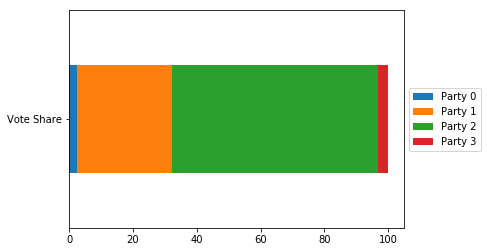

In [3]:
rvs = random_vote_share(n=4, mode='float')
rvs_labels = [f'Party {i}: {x:.1f}%' for i, x in enumerate(rvs)]
print(f'Vote shares: {rvs_labels}')
pd.DataFrame(rvs, index=[f'Party {i}' for i in range(len(rvs))], columns=['Vote Share']).T.plot(kind='barh', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

## D'Hont implementation

In [4]:
def run_dhont(n_seats=4, n_parties=4, vote_share=None, debug=True):
    seats_won = [0] * n_parties
    seats_remaining = n_seats

    if vote_share is None:
        vote_share = random_vote_share(n=n_parties)

    if debug:
        print(f'Vote shares: {vote_share}')

    while seats_remaining:
        quotients = list(map(lambda x: x[0]/(1+x[1]), zip(vote_share, seats_won)))
        if debug:
            print(f'  Quotients: {quotients}')
        # silently ignoring the possibility that there is a tie and just picking the first party on the highest score...
        winning_index = quotients.index(max(quotients))
        if debug:
            print(f'Party {winning_index} wins a seat')
        seats_won[winning_index] += 1
        seats_remaining -= 1
    
    if debug:
        print('All seats are now allocated')
    return vote_share, seats_won

### Run the D'Hont election on the random vote shares plotted above (4 parties contesting 4 seats)

In [5]:
vs, seats = run_dhont(n_seats=4, n_parties=4, vote_share=rvs)
print()
for i, s in enumerate(seats):
    print(f'Party {i} wins {s} seats')

Vote shares: [2.535975944505031, 29.66658467877138, 64.77820531736464, 3.0192340593589506]
  Quotients: [2.535975944505031, 29.66658467877138, 64.77820531736464, 3.0192340593589506]
Party 2 wins a seat
  Quotients: [2.535975944505031, 29.66658467877138, 32.38910265868232, 3.0192340593589506]
Party 2 wins a seat
  Quotients: [2.535975944505031, 29.66658467877138, 21.59273510578821, 3.0192340593589506]
Party 1 wins a seat
  Quotients: [2.535975944505031, 14.83329233938569, 21.59273510578821, 3.0192340593589506]
Party 2 wins a seat
All seats are now allocated

Party 0 wins 0 seats
Party 1 wins 1 seats
Party 2 wins 3 seats
Party 3 wins 0 seats


### Run the D'Hont election on the vote shares in the worked example from above
 | Party | Party 0 | Party 1 | Party 2 | Party 3 |
 | --- | --- | --- | --- | --- |
 | Votes | 30 | 32 | 28 | 10 |


In [6]:
vs, seats = run_dhont(n_seats=5, n_parties=4, vote_share=[30,32,28,10])
assert(seats==[2, 2, 1, 0])
print()
for i, s in enumerate(seats):
    print(f'Party {i} wins {s} seats')

Vote shares: [30, 32, 28, 10]
  Quotients: [30.0, 32.0, 28.0, 10.0]
Party 1 wins a seat
  Quotients: [30.0, 16.0, 28.0, 10.0]
Party 0 wins a seat
  Quotients: [15.0, 16.0, 28.0, 10.0]
Party 2 wins a seat
  Quotients: [15.0, 16.0, 14.0, 10.0]
Party 1 wins a seat
  Quotients: [15.0, 10.666666666666666, 14.0, 10.0]
Party 0 wins a seat
All seats are now allocated

Party 0 wins 2 seats
Party 1 wins 2 seats
Party 2 wins 1 seats
Party 3 wins 0 seats


## Run a sample of random elections


In [7]:
n_parties = 6
n_seats = 4

n_elections = 5000

def mk_sample_df(n_parties=n_parties, n_seats=n_seats, n_elections=n_elections):
    l = []

    for _ in range(n_elections):
        l += list(zip(*run_dhont(n_seats, n_parties, debug=False)))

    df = pd.DataFrame(l, columns=['vote_percentage', 'number_of_seats'])
    df['seat_percentage'] = 100.0 * df['number_of_seats'] / n_seats
    df['proportionality_difference'] = df['seat_percentage'] - df['vote_percentage']
    return df

# generate a few datasets for different numbers of parties
dfs = {}
for n_p in range(n_parties - 4, n_parties + 3, 2):
    print(f'Simulating {n_elections} elections for {n_p} parties contesting {n_seats} seats')
    dfs[n_p] = mk_sample_df(n_parties=n_p)

# pick one dataframe for the main plots
df = dfs[n_parties]
df.head()

Simulating 5000 elections for 2 parties contesting 4 seats
Simulating 5000 elections for 4 parties contesting 4 seats
Simulating 5000 elections for 6 parties contesting 4 seats
Simulating 5000 elections for 8 parties contesting 4 seats


,vote_percentage,number_of_seats,seat_percentage,proportionality_difference
0,43.141529,2,50.0,6.858471
1,0.579983,0,0.0,-0.579983
2,11.092497,0,0.0,-11.092497
3,2.740865,0,0.0,-2.740865
4,4.910428,0,0.0,-4.910428


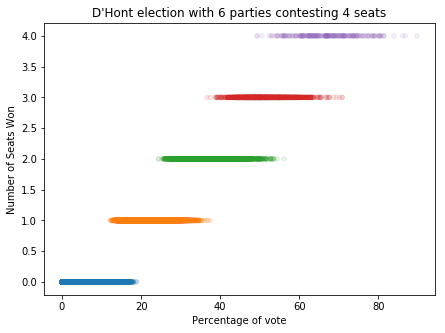

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
df.plot(kind='scatter', x='vote_percentage', y='number_of_seats', color=df['number_of_seats'].apply(lambda x: f'C{x}'), alpha=0.1, ax=ax)
ax.set_title(f"D'Hont election with {n_parties} parties contesting {n_seats} seats")
ax.set_ylabel('Number of Seats Won')
ax.set_xlabel('Percentage of vote')
plt.savefig(f'dhont_scatter_{n_parties}_parties_{n_seats}_seats.png')

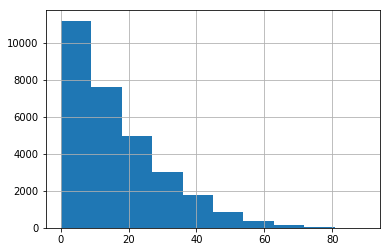

In [9]:
df.vote_percentage.hist();

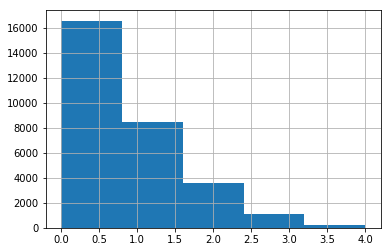

In [10]:
df.number_of_seats.hist(bins=n_seats+1);

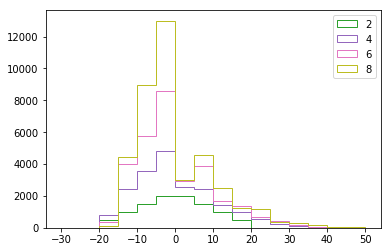

In [17]:
for n_p in range(n_parties - 4, n_parties + 3, 2):
    dfs[n_p].proportionality_difference.hist(bins=range(-30,51,5), histtype='step', grid=False, color=f'C{n_p}', label=f'{n_p}');
plt.legend()

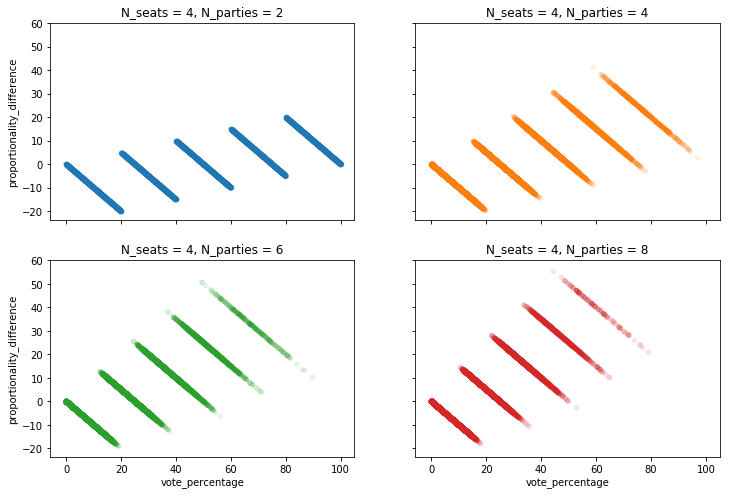

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)
#fig, ax = plt.subplots(figsize=(12,8))
ax = ax.flatten()
for a, n_p in enumerate(range(n_parties - 4, n_parties + 3, 2)):
    dfs[n_p].plot(kind='scatter', x='vote_percentage', y='proportionality_difference', c=f'C{a}', alpha=0.1, ax=ax[a])
    ax[a].set_title(f'N_seats = 4, N_parties = {n_p}')
#plt.legend()

In [14]:
# fig, ax = plt.subplots(figsize=(12,8))
# for i in sorted(df['number_of_seats'].unique()):
#     df[df['number_of_seats']==i]['vote_percentage'].plot(kind='kde', label=f'{i} seats', ax=ax)
#     #sns.kdeplot(df[df['number_of_seats']==i]['vote_percentage'], label=f'{i} seats', shade=True)
# ax.legend()
# ax.set_xlim([0,100])
# ax.set_title(f"D'Hont election with {n_parties} parties contesting {n_seats} seats")
# ax.set_xlabel('Percentage of vote');

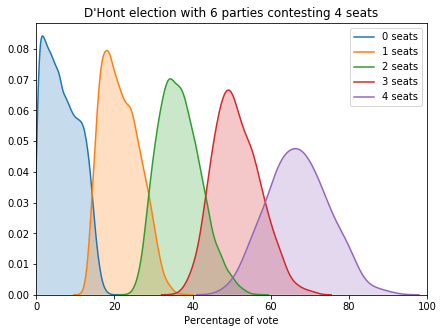

In [15]:
fig, ax = plt.subplots(figsize=(7,5))
for i in sorted(df['number_of_seats'].unique()):
    #df[df['number_of_seats']==i]['vote_percentage'].plot(kind='kde', label=f'{i} seats', ax=ax, )
    sns.kdeplot(df[df['number_of_seats']==i]['vote_percentage'], label=f'{i} seats', shade=True)
    #plt.hist(df[df['number_of_seats']==i]['vote_percentage'], normed=True, alpha=0.1, bins=range(0,100,4), color=f'C{i}', )
ax.legend()
ax.set_xlabel('Percentage of vote')
ax.set_title(f"D'Hont election with {n_parties} parties contesting {n_seats} seats")
ax.set_xlim([0,100])
plt.savefig(f'dhont_kde_{n_parties}_parties_{n_seats}_seats.png')

In [16]:
# df.groupby('number_of_seats')['vote_percentage'].plot(kind='kde');

# Twitter thread preparation

A lot has been discussed about how the D'Hont system for PR favours 